# Shap Analysis

## Packages and Data

In [32]:
import pandas as pd
import joblib
import json
import shap

In [33]:
# model_path = "../../data/data_for_shap_analysis/random_forest_20251022_115449.joblib"
# model = joblib.load(model_path)

## Data Preprocessing

In [34]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import pandas as pd
import numpy as np
from general_utils.constants import spectral_bands, indices
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

bands_and_indices = spectral_bands + indices

import shap
import seaborn as sns

In [5]:
from pipelines.processing.processing_pipeline import ProcessingPipeline

from pipelines.processing.features.spectral_indices import CalculateIndices
from pipelines.processing.features.basic_features import BasicFeatures
from pipelines.processing.features.temporal_features import TemporalFeatures

from pipelines.processing.processing_steps.interpolation import Interpolation

PATH_TRAIN = "../../data/preprocessed/trainset.csv"
PATH_TEST = "../../data/preprocessed/testset.csv"

In [6]:
steps = [
    BasicFeatures(on=True),
    Interpolation(on=True),
    CalculateIndices(on=True),
    TemporalFeatures(on=True),
]

pipeline_train = ProcessingPipeline(path=PATH_TRAIN, steps=steps)
df_train = pipeline_train.run()

pipeline_test = ProcessingPipeline(path=PATH_TEST, steps=steps)
df_test = pipeline_test.run()

drop_cols = ["disturbance_year", "is_disturbed", "date_diff"]

df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

## Prepare Data

Per ID one row with key figures. 

For every Band & Index: month_band_mean / std / min / max

-> With this kind of data structure, a simple model is possible.

In [7]:
def calculate_keyfigures_per_id(df, bands_and_indices):
    """
    Aggregates features per 'id' by month and computes key statistics:
    mean, std, min, max for each feature in bands_and_indices
    """
    df = df.copy()
    df["month"] = df["time"].dt.month_name()

    monthly_agg = df.groupby(["id", "month"])[bands_and_indices].agg(
        ["mean", "std", "min", "max"]
    )

    monthly_agg.columns = [
        "_".join([col[0], col[1]]) for col in monthly_agg.columns.values
    ]
    monthly_agg = monthly_agg.reset_index()

    df_train = monthly_agg.pivot(
        index="id", columns="month", values=monthly_agg.columns[1:]
    )

    df_train.columns = ["_".join(col).strip() for col in df_train.columns.values]
    df_train = df_train.reset_index()

    labels = df.groupby("id")["species"].first().reset_index()
    df_train = df_train.merge(labels, on="id", how="left")

    df_train = df_train.drop(
        columns=[col for col in df_train.columns if "month_" in col]
    )

    # dtypes
    feature_cols = df_train.columns.drop("species")
    for col in feature_cols:
        df_train[col] = pd.to_numeric(df_train[col], errors="coerce")

    return df_train

In [8]:
df_train = calculate_keyfigures_per_id(df_train, bands_and_indices)
# df_test = calculate_keyfigures_per_id(df_test, bands_and_indices)

## Baseline Model

In [9]:
le = LabelEncoder()

df_train = df_train.drop(columns=["id"])
df_train.loc[:, "species_encoded"] = le.fit_transform(df_train["species"])
y = df_train["species_encoded"]

X = df_train.drop(["species", "species_encoded"], axis=1)

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

xgb_baseline_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric="mlogloss",
    use_label_encoder=False,
    objective="multi:softprob",
    num_class=len(le.classes_),
)

xgb_baseline_model.fit(X_train, y_train)

y_pred = xgb_baseline_model.predict(X_test)

if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)

y_prob = xgb_baseline_model.predict_proba(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

target_names = [str(cls) for cls in le.classes_]
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

C:\Users\evely\AppData\Local\Temp\ipykernel_13692\2177855209.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train.loc[:, "species_encoded"] = le.fit_transform(df_train["species"])
c:\Users\evely\OneDrive - bwedu\Documents\Uni\7. Semester\AWP2\tree_classification\.tree_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:08:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[ 758  233    4    1   12    0    1]
 [ 145 1491   20   25   15    3    5]
 [   0   23 1250    0   24    1    1]
 [   0   21    0  306    1    4    2]
 [  20   30   88    3  582    0    3]
 [   0   10    1    3    1   86    4]
 [   0    2    3    1    7    0  735]]

Classification Report:
                     precision    recall  f1-score   support

      Norway_spruce       0.82      0.75      0.78      1009
Norway_spruce_mixed       0.82      0.88      0.85      1704
         Scots_pine       0.92      0.96      0.94      1299
              beech       0.90      0.92      0.91       334
          disturbed       0.91      0.80      0.85       726
                oak       0.91      0.82      0.86       105
               soil       0.98      0.98      0.98       748

           accuracy                           0.88      5925
          macro avg       0.89      0.87      0.88      5925
       weighted avg       0.88      0.88      0.88      5925



## Feature Analysis

In [10]:
X_for_shap = X_test.copy()

explainer = shap.TreeExplainer(xgb_baseline_model)
shap_values = explainer(
    X_for_shap
)  # multiclass -> list, shape (n_classes, n_samples, n_features)

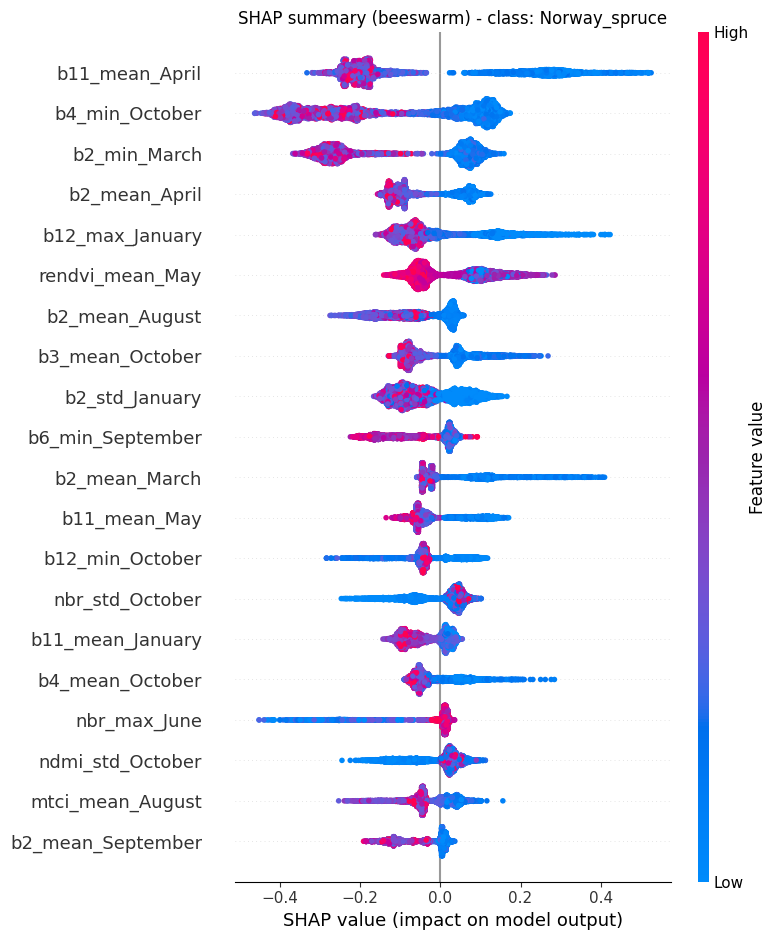

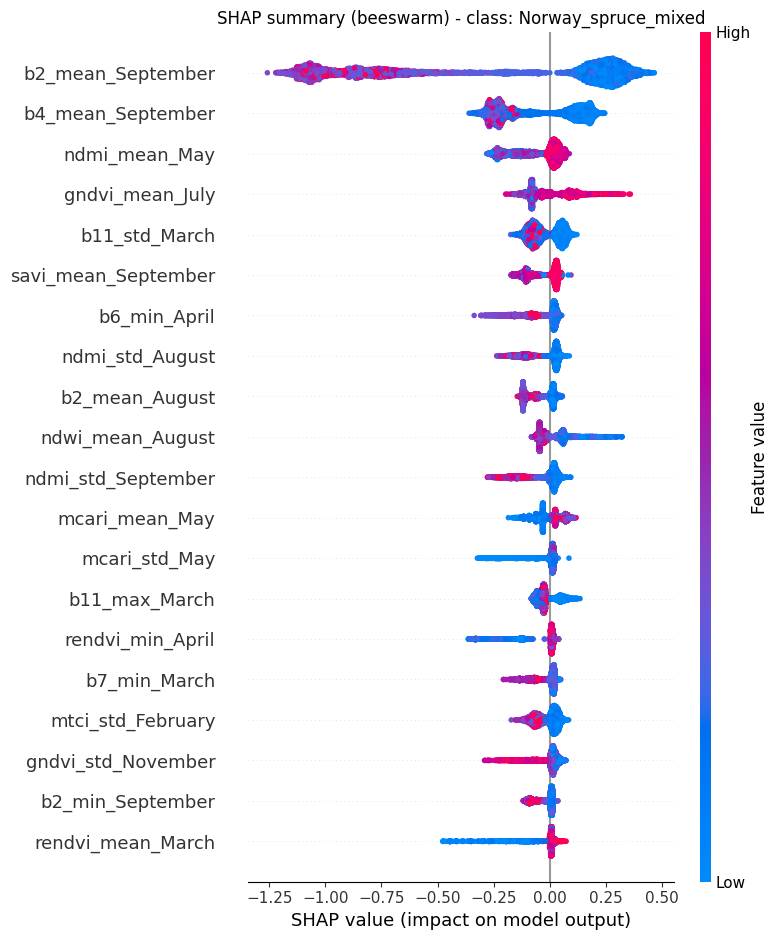

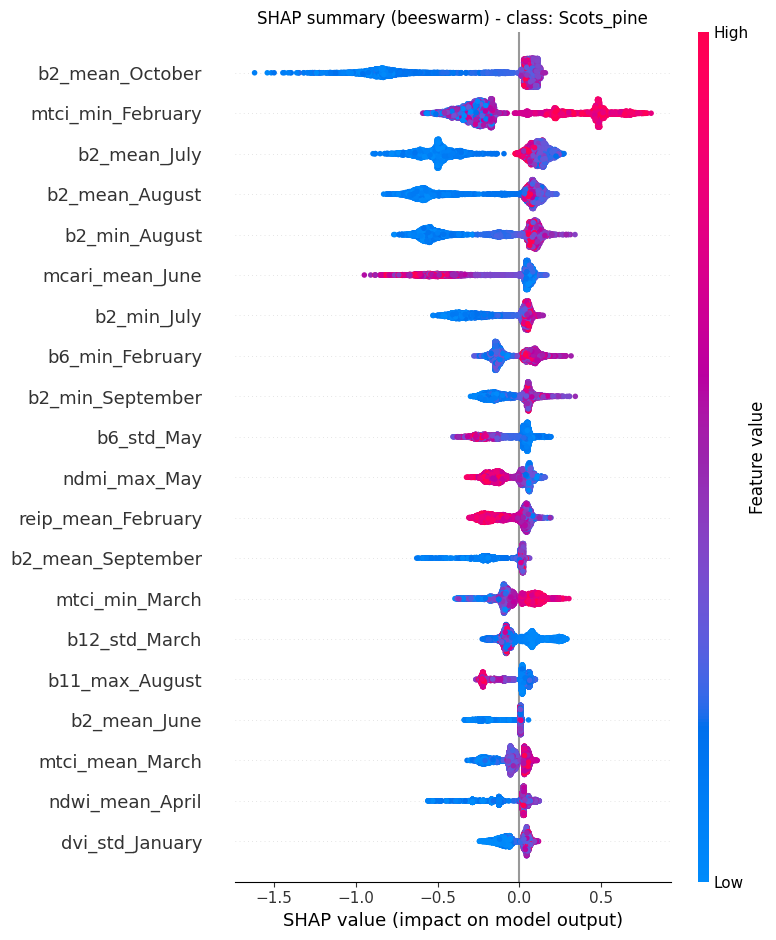

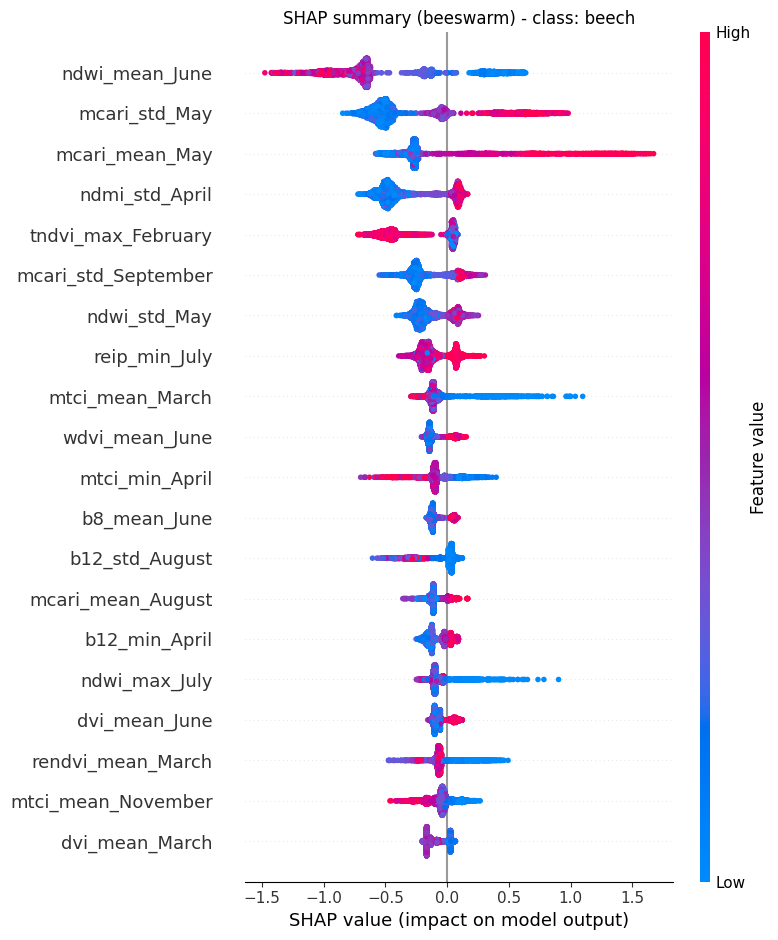

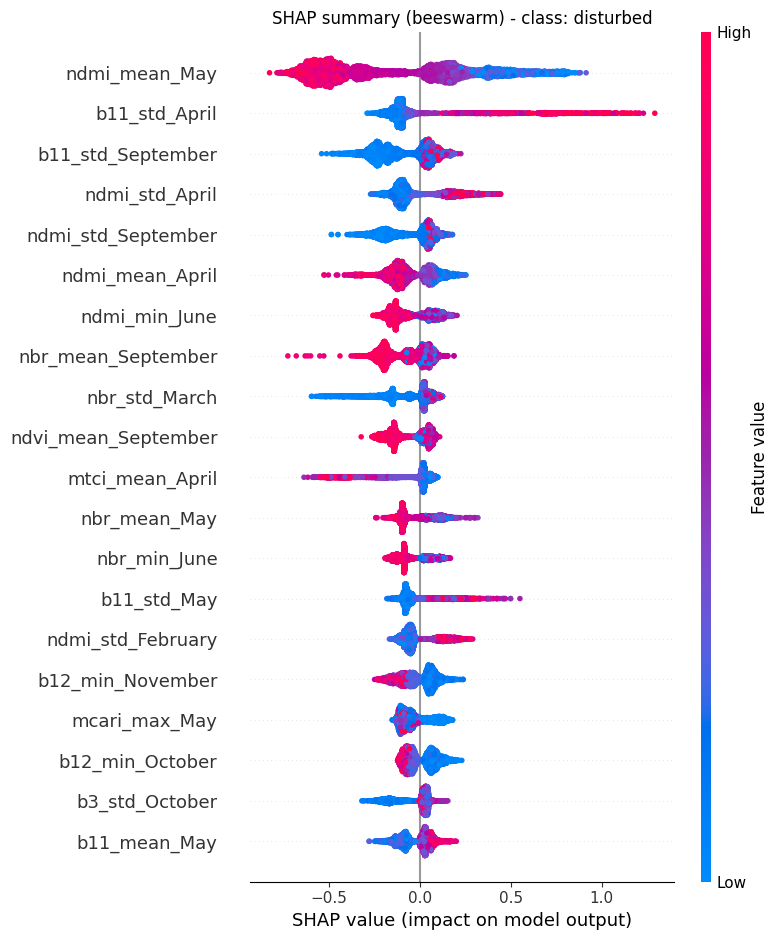

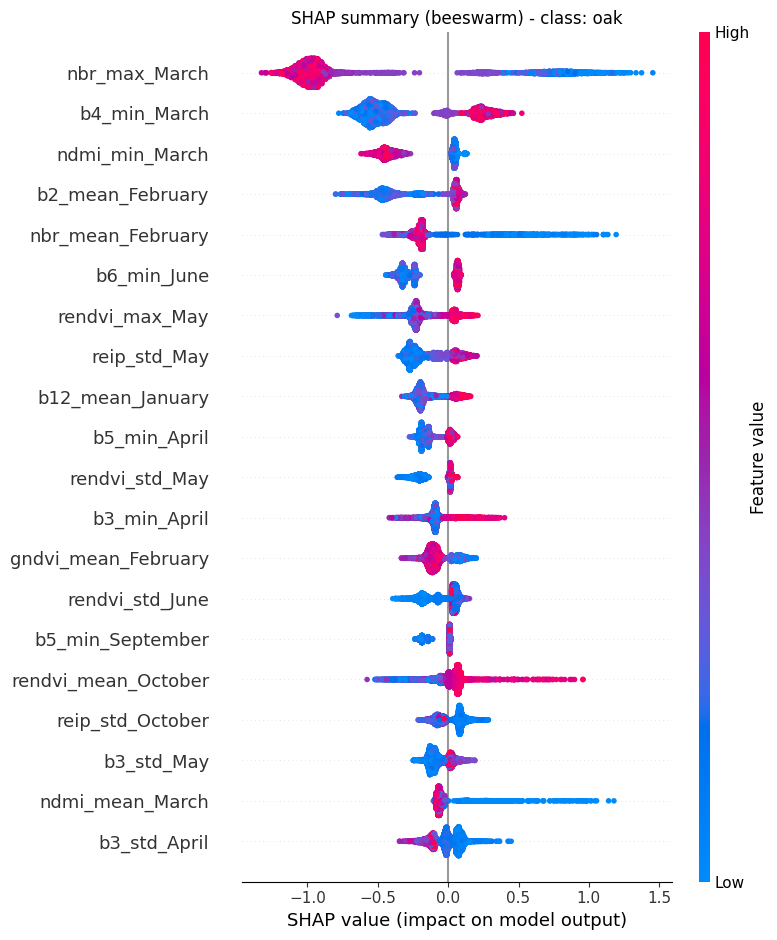

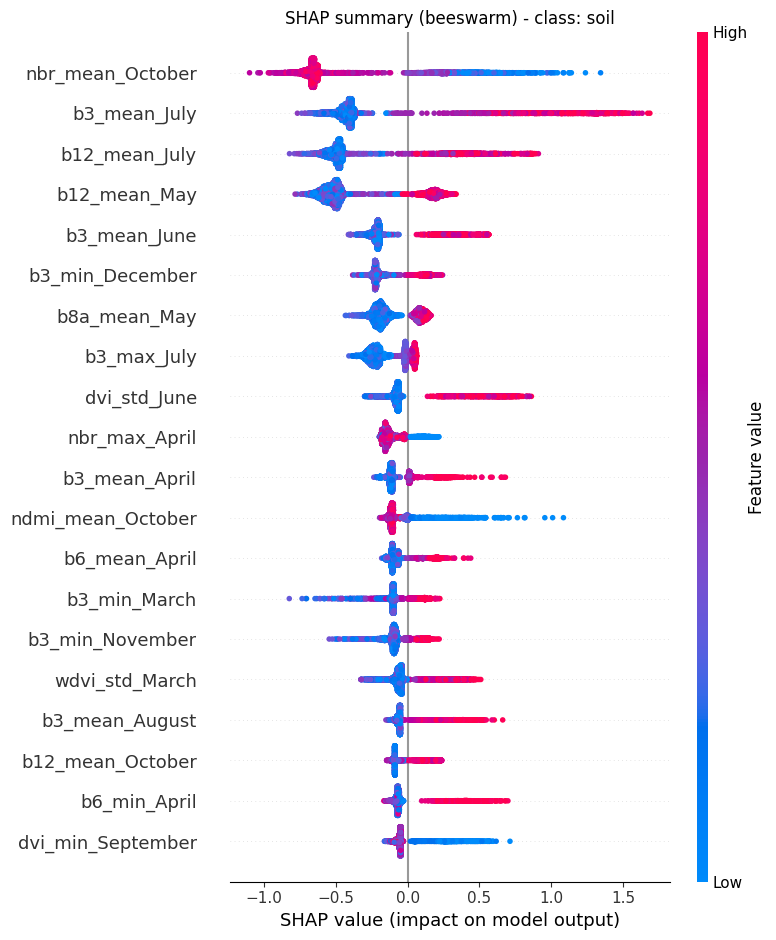

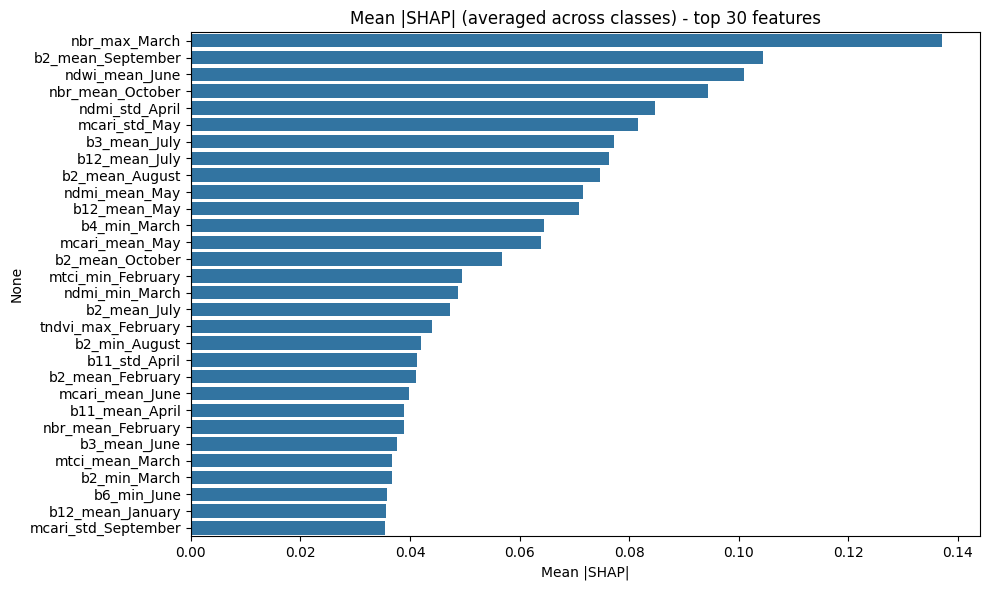

In [11]:
# summary per class
for i, cls in enumerate(le.classes_):
    shap.summary_plot(shap_values.values[:, :, i], X_for_shap, show=False)
    plt.title(f"SHAP summary (beeswarm) - class: {cls}")
    plt.tight_layout()
    plt.show()

# Global mean(|SHAP|) bar (averaged across classes)
mean_abs = np.mean(
    np.abs(shap_values.values), axis=(0, 2)
)  # average over samples & classes
feat_imp = pd.Series(mean_abs, index=X_for_shap.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:30], y=feat_imp.index[:30])
plt.title("Mean |SHAP| (averaged across classes) - top 30 features")
plt.xlabel("Mean |SHAP|")
plt.tight_layout()
plt.show()

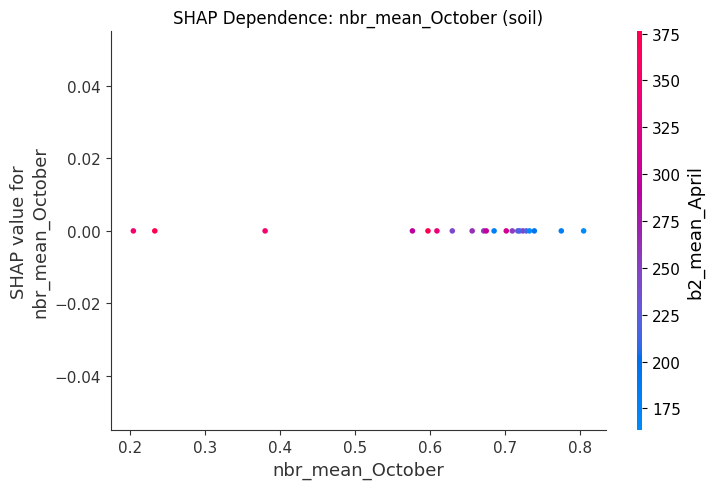

In [43]:
feat = "nbr_mean_October"  #
class_idx = 6

# Dependence-Plot
shap.dependence_plot(
    feat,
    shap_values.values[:, :, class_idx],
    X_for_shap,
    interaction_index="auto",
    show=False,
)

plt.title(f"SHAP Dependence: {feat} ({le.classes_[class_idx]})")
plt.tight_layout()
plt.show()

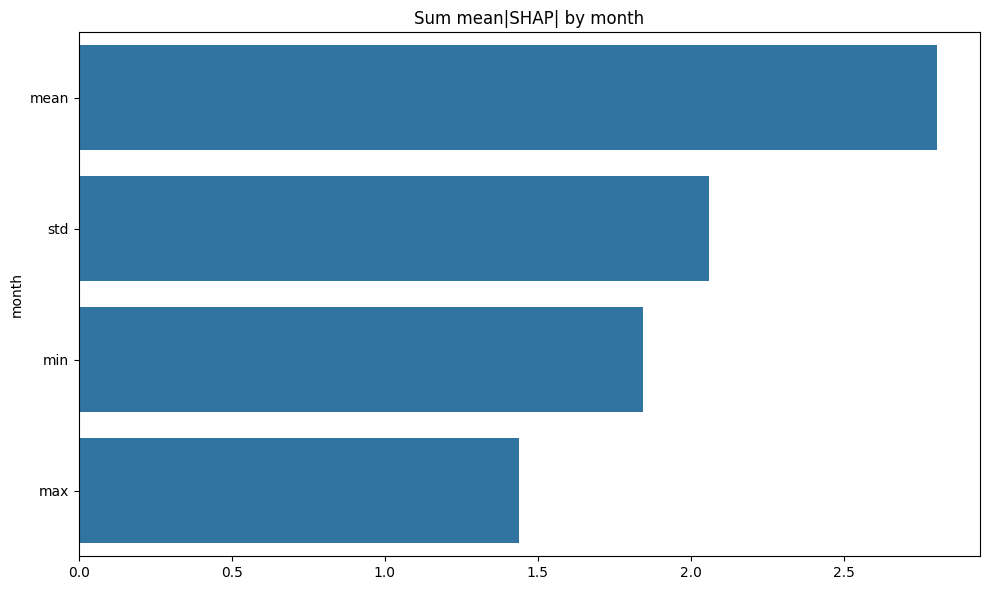

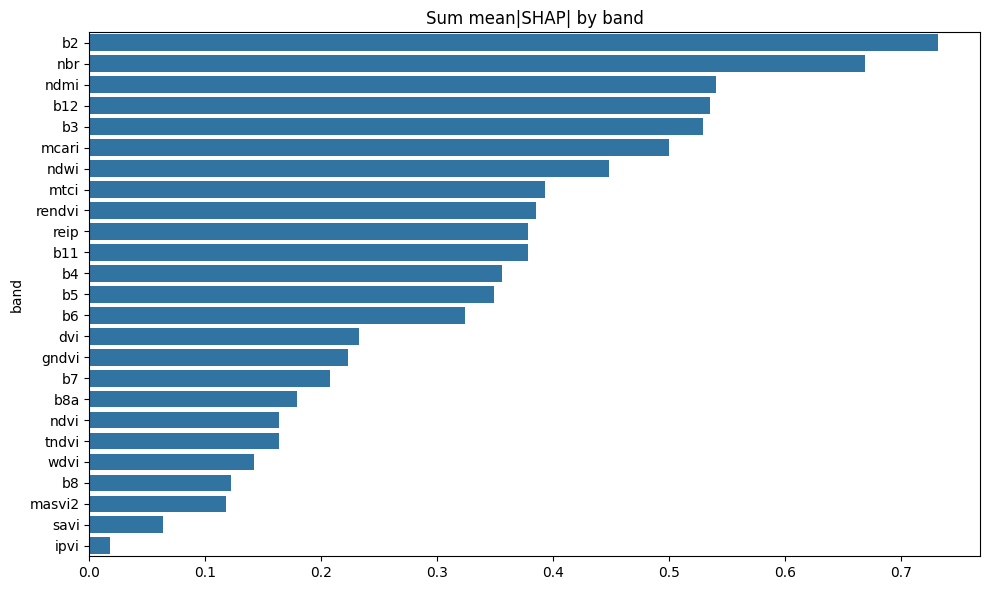

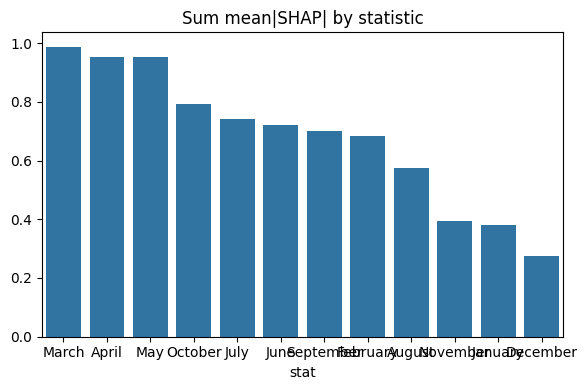

In [13]:
def parse_feature_name(col):
    parts = col.split("_")
    if len(parts) >= 3:
        band = parts[0]
        month = parts[1]
        stat = parts[2]
    else:
        band, month, stat = ("unknown", "unknown", "unknown")
    return band, month, stat


feat_info = pd.DataFrame(
    [parse_feature_name(c) for c in X_for_shap.columns],
    columns=["band", "month", "stat"],
    index=X_for_shap.columns,
)

shap_mean_abs = pd.Series(mean_abs, index=X_for_shap.columns)
# Group by month
by_month = shap_mean_abs.groupby(feat_info["month"]).sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=by_month.values, y=by_month.index)
plt.title("Sum mean|SHAP| by month")
plt.tight_layout()
plt.show()

# Group by band
by_band = shap_mean_abs.groupby(feat_info["band"]).sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=by_band.values, y=by_band.index)
plt.title("Sum mean|SHAP| by band")
plt.tight_layout()
plt.show()

# Group by statistic (mean/std/min/max)
by_stat = shap_mean_abs.groupby(feat_info["stat"]).sum().sort_values(ascending=False)
plt.figure(figsize=(6, 4))
sns.barplot(x=by_stat.index, y=by_stat.values)
plt.title("Sum mean|SHAP| by statistic")
plt.tight_layout()
plt.show()